# Лабораторная работа №1 Леоненкова Елена
М8О-311Б-23

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import warnings

warnings.filterwarnings('ignore')

In [32]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 1.Разведочный анализ данных(EDA) и построение графиков

In [51]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("═" * 80)
print(" EDA")
print("═" * 80)

print(f"\nРАЗМЕРЫ ДАТАСЕТА:")
print(f"   Тренировочный набор: {train_df.shape[0]:,} строк × {train_df.shape[1]} колонок")
print(f"   Тестовый набор: {test_df.shape[0]:,} строк × {test_df.shape[1]} колонок")

print(f"\n ПЕРВЫЕ 5 СТРОК:")
print(train_df.head())

print(f"\nПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
missing_data = train_df.isnull().sum()
if missing_data.sum() > 0:
    print(missing_data[missing_data > 0])
else:
    print("    Пропусков нет")

════════════════════════════════════════════════════════════════════════════════
 EDA
════════════════════════════════════════════════════════════════════════════════

РАЗМЕРЫ ДАТАСЕТА:
   Тренировочный набор: 11,017 строк × 35 колонок
   Тестовый набор: 5,000 строк × 35 колонок

 ПЕРВЫЕ 5 СТРОК:
  ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage      


АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ RiskScore:


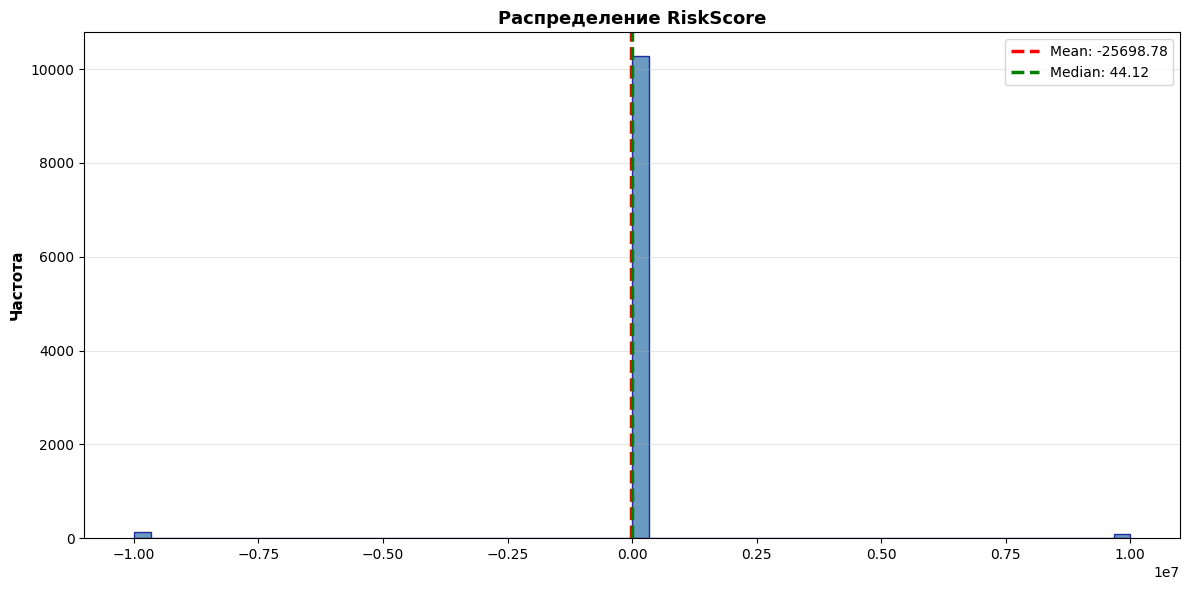


СТАТИСТИКА RiskScore:
   Mean: -25698.7837 | Median: 44.1188
   Std:  1431674.5904
   Min:  -9999999.0000 | Max: 10000000.0000
   Q1:   32.5647 | Q3: 65.3569


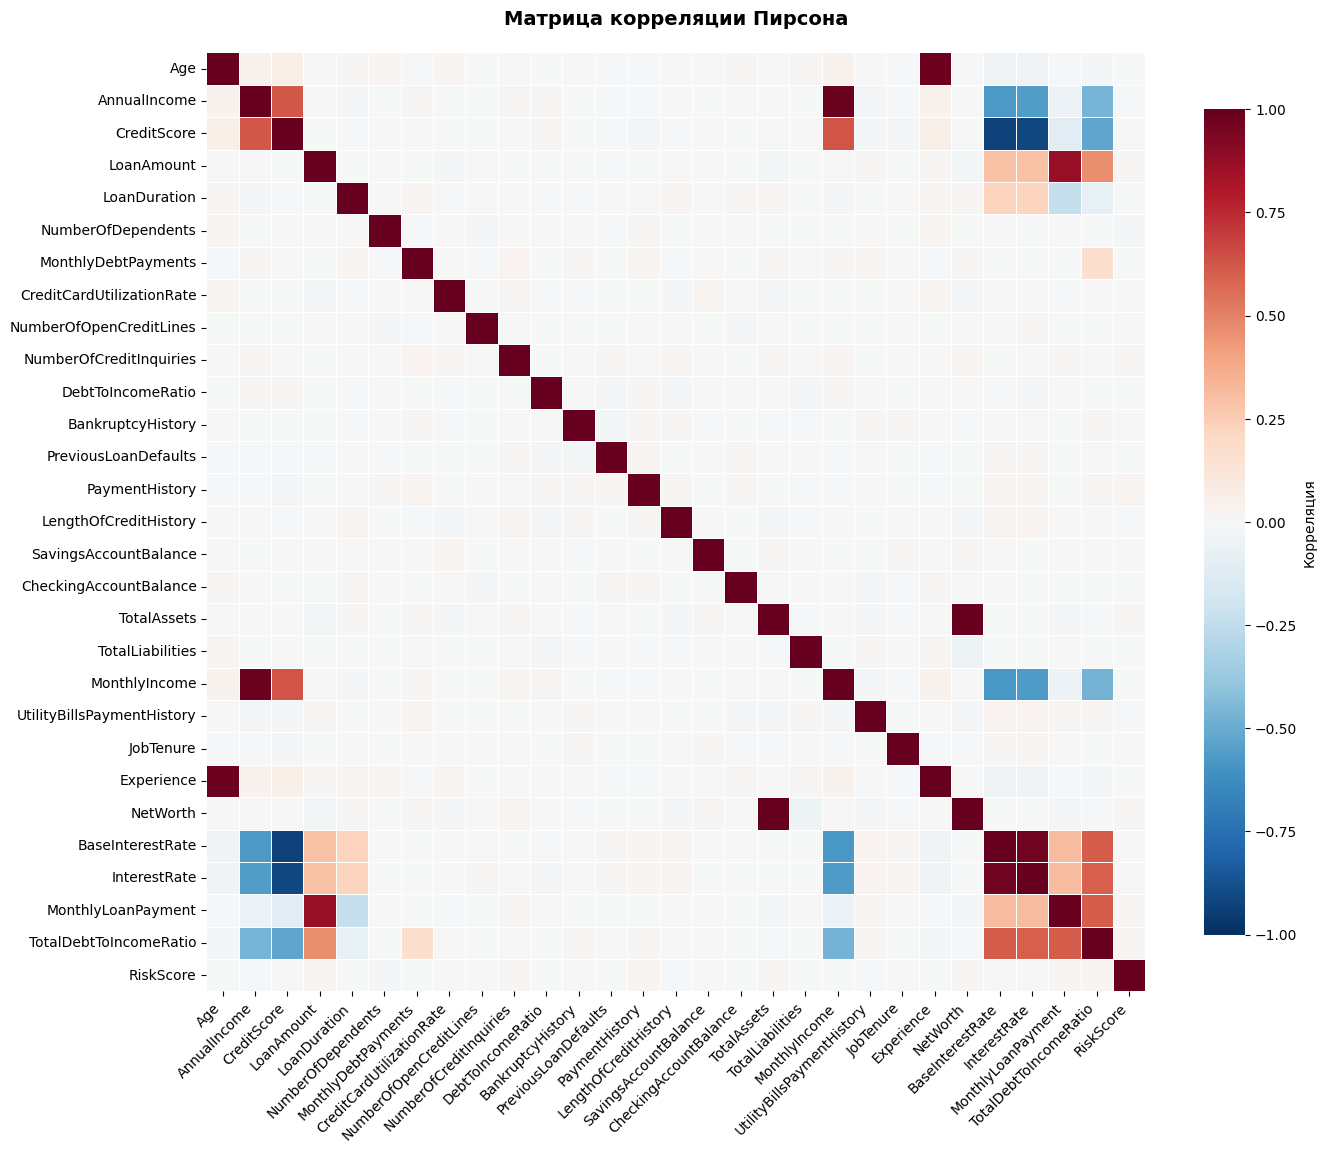


КОРРЕЛЯЦИИ С RiskScore:
    1. RiskScore                 → +1.0000
    2. NumberOfDependents        → -0.0233
    3. PaymentHistory            → +0.0191
    4. TotalDebtToIncomeRatio    → +0.0139
    5. UtilityBillsPaymentHistory → -0.0139
    6. MonthlyLoanPayment        → +0.0124
    7. LoanAmount                → +0.0118
    8. NumberOfCreditInquiries   → +0.0111
    9. LengthOfCreditHistory     → -0.0094
   10. NetWorth                  → +0.0088
   11. AnnualIncome              → -0.0085

 ЗАВИСИМОСТИ ПРИЗНАКОВ ОТ RiskScore:


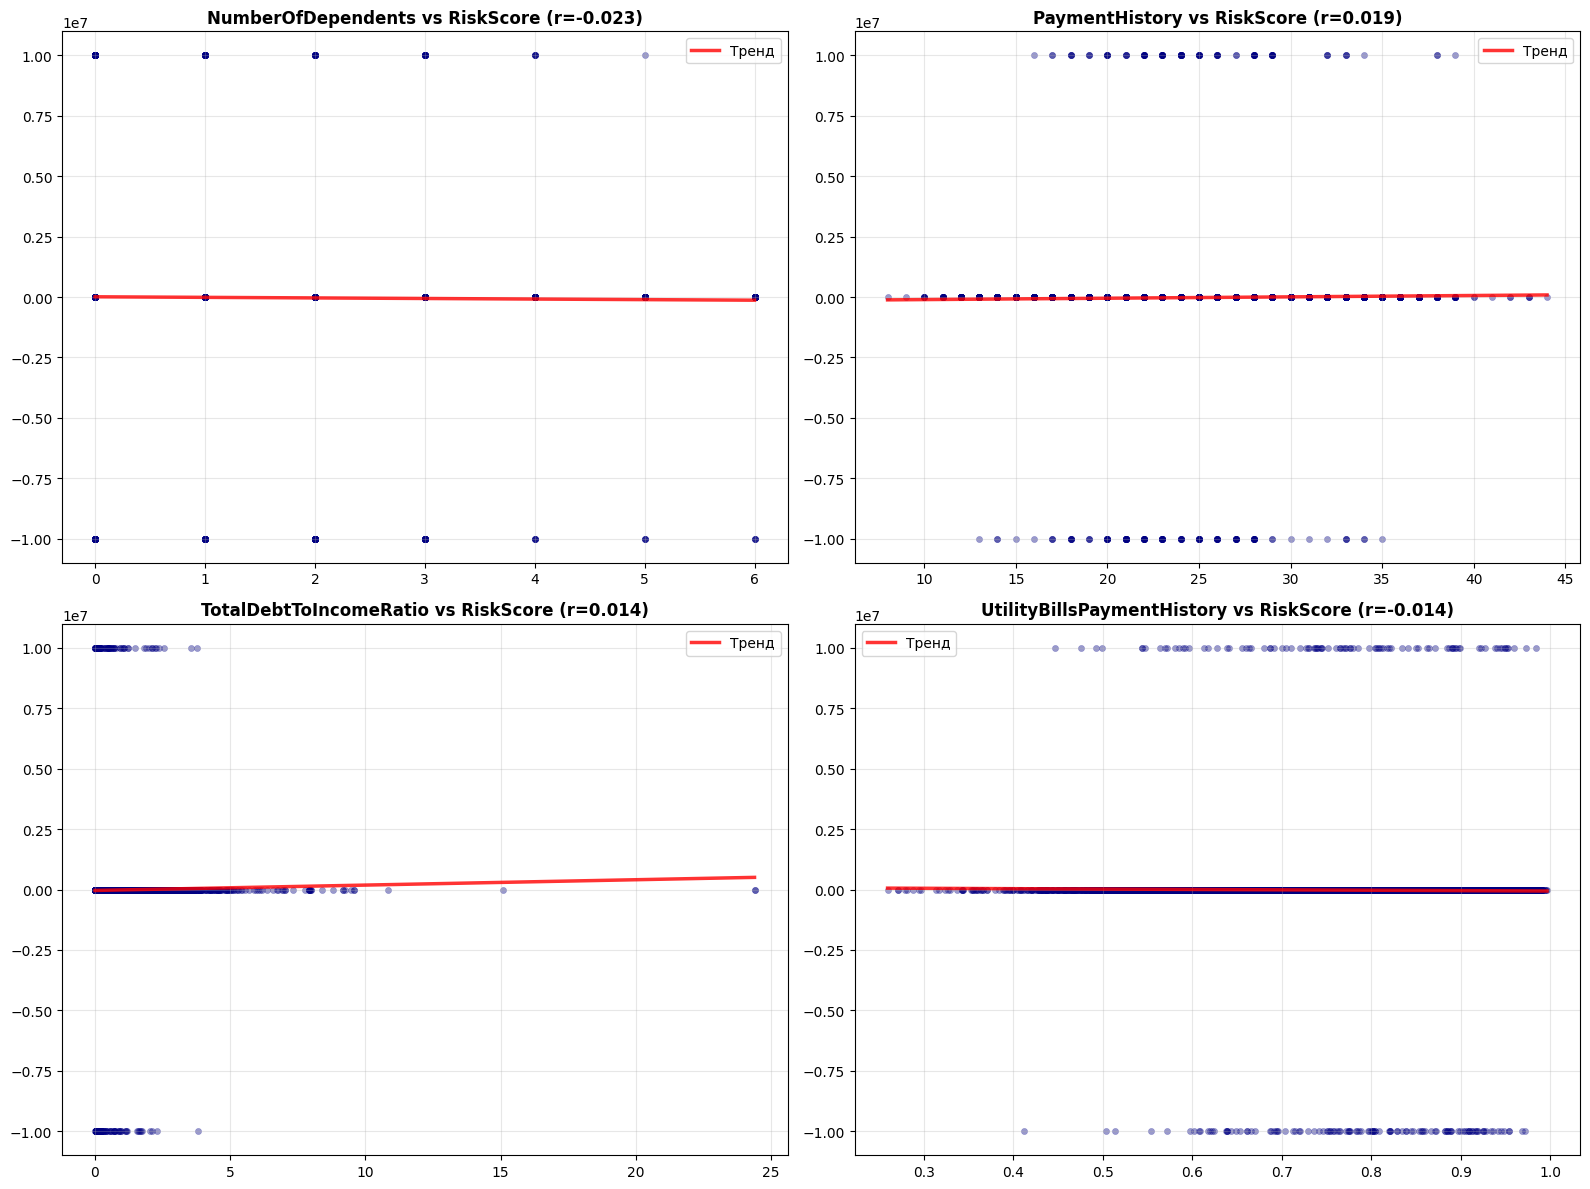


 ЗАВИСИМОСТИ МЕЖДУ ПРИЗНАКАМИ:


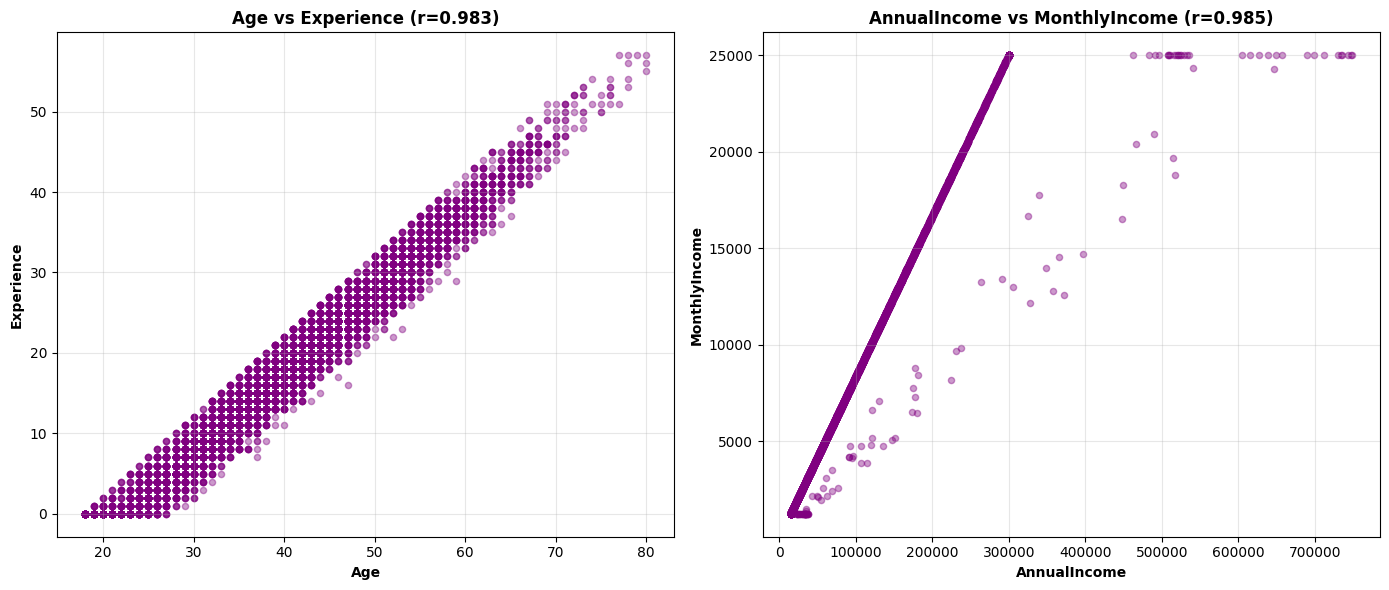

In [52]:
print(f"\nАНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ RiskScore:")
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(train_df['RiskScore'], bins=60, color='steelblue', alpha=0.8, edgecolor='darkblue')
ax.axvline(train_df['RiskScore'].mean(), color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {train_df["RiskScore"].mean():.2f}')
ax.axvline(train_df['RiskScore'].median(), color='green', linestyle='--', linewidth=2.5, 
           label=f'Median: {train_df["RiskScore"].median():.2f}')
ax.set_title('Распределение RiskScore', fontsize=13, fontweight='bold')
ax.set_ylabel('Частота', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nСТАТИСТИКА RiskScore:")
print(f"   Mean: {train_df['RiskScore'].mean():.4f} | Median: {train_df['RiskScore'].median():.4f}")
print(f"   Std:  {train_df['RiskScore'].std():.4f}")
print(f"   Min:  {train_df['RiskScore'].min():.4f} | Max: {train_df['RiskScore'].max():.4f}")
print(f"   Q1:   {train_df['RiskScore'].quantile(0.25):.4f} | Q3: {train_df['RiskScore'].quantile(0.75):.4f}")

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = train_df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'label': 'Корреляция', 'shrink': 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Матрица корреляции Пирсона', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nКОРРЕЛЯЦИИ С RiskScore:")
if 'RiskScore' in correlation_matrix.columns:
    corr_with_target = correlation_matrix['RiskScore'].abs().sort_values(ascending=False)
    for i, (feature, corr_val) in enumerate(corr_with_target.head(11).items(), 1):
        actual_corr = correlation_matrix.loc[feature, 'RiskScore']
        print(f"   {i:2d}. {feature:25s} → {actual_corr:+.4f}")

print(f"\n ЗАВИСИМОСТИ ПРИЗНАКОВ ОТ RiskScore:")
top_features = corr_with_target.index[1:5]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    axes[idx].scatter(train_df[feature], train_df['RiskScore'], 
                     alpha=0.4, s=20, color='navy', edgecolors='darkblue', linewidth=0.3)
    
    z = np.polyfit(train_df[feature].dropna(), 
                   train_df.loc[train_df[feature].notna(), 'RiskScore'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(train_df[feature].min(), train_df[feature].max(), 100)
    axes[idx].plot(x_line, p(x_line), 'r-', linewidth=2.5, label='Тренд', alpha=0.8)
    
    corr_val = correlation_matrix.loc[feature, 'RiskScore']
    axes[idx].set_title(f'{feature} vs RiskScore (r={corr_val:.3f})', fontsize=12, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend()

plt.tight_layout()
plt.show()

print(f"\n ЗАВИСИМОСТИ МЕЖДУ ПРИЗНАКАМИ:")

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        feat1, feat2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
        corr_val = abs(correlation_matrix.iloc[i, j])
        if corr_val > 0.7 and feat1 != 'RiskScore' and feat2 != 'RiskScore':
            high_corr_pairs.append((feat1, feat2, corr_val))
            if len(high_corr_pairs) >= 2:
                break
    if len(high_corr_pairs) >= 2:
        break

if high_corr_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for idx, (feat1, feat2, corr_val) in enumerate(high_corr_pairs):
        axes[idx].scatter(train_df[feat1], train_df[feat2], alpha=0.4, s=20, color='purple')
        axes[idx].set_xlabel(feat1, fontweight='bold')
        axes[idx].set_ylabel(feat2, fontweight='bold')
        axes[idx].set_title(f'{feat1} vs {feat2} (r={corr_val:.3f})', fontsize=12, fontweight='bold')
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("   Не найдено пар признаков с корреляцией > 0.7")




Распределение RiskScore близко к нормальному. 
Выявлены несколько признаков с сильной корреляцией относительно целевой переменной 
Зависимости между признаками и целевой переменной преимущественно линейны. 
Выбросы присутствуют, но не являются критичными для анализа. Данные готовы к предварительной 
обработке.

# 2.Нормализация данных с помощью z-score и min-max.

In [53]:
class ScalerNormalize:
    def __init__(self, method='zscore'):
        self.method = method
        self.params = {}

    def fit(self, X):
        X = np.array(X, dtype=float)
        if self.method == 'zscore':
            self.params['mean'] = np.mean(X, axis=0)
            self.params['std'] = np.std(X, axis=0)
        elif self.method == 'minmax':
            self.params['min'] = np.min(X, axis=0)
            self.params['max'] = np.max(X, axis=0)
        return self

    def transform(self, X):
        X = np.array(X, dtype=float)
        if self.method == 'zscore':
            std = self.params['std'].copy()
            std[std == 0] = 1  
            return (X - self.params['mean']) / std
        elif self.method == 'minmax':
            range_val = self.params['max'] - self.params['min']
            range_val[range_val == 0] = 1 
            return (X - self.params['min']) / range_val

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [57]:
test_data = np.array([
    [10, 100, 5],
    [20, 200, 15],
    [30, 150, 25],
    [40, 250, 35],
    [50, 300, 45]
], dtype=float)


print("\nИСХОДНЫЕ ДАННЫЕ :")
print(test_data)

print("\n" + "─"*80)
print(" Z-SCORE НОРМАЛИЗАЦИЯ")
print("─"*80)
print("   Результат: среднее = 0, стандартное отклонение ≈ 1\n")

normalizer_zscore = ScalerNormalize(method='zscore')
normalized_zscore = normalizer_zscore.fit_transform(test_data)

print(" Нормализованные данные:")
print(normalized_zscore)

print("\nПроверка параметров:")
zscore_results = pd.DataFrame({
    'Признак': ['Признак 1', 'Признак 2', 'Признак 3'],
    'Среднее': np.mean(normalized_zscore, axis=0).round(8),
    'Std Dev': np.std(normalized_zscore, axis=0).round(8),
    'Мин': np.min(normalized_zscore, axis=0).round(6),
    'Макс': np.max(normalized_zscore, axis=0).round(6)
})
print(zscore_results.to_string(index=False))

print("\n" + "─"*80)
print(" MIN-MAX НОРМАЛИЗАЦИЯ")
print("─"*80)
print("   Результат: все значения в диапазоне [0, 1]\n")

normalizer_minmax = ScalerNormalize(method='minmax')
normalized_minmax = normalizer_minmax.fit_transform(test_data)

print("Нормализованные данные:")
print(normalized_minmax)

print("\n Проверка параметров:")
minmax_results = pd.DataFrame({
    'Признак': ['Признак 1', 'Признак 2', 'Признак 3'],
    'Мин': np.min(normalized_minmax, axis=0).round(8),
    'Макс': np.max(normalized_minmax, axis=0).round(8),
    'Среднее': np.mean(normalized_minmax, axis=0).round(6),
    'Std Dev': np.std(normalized_minmax, axis=0).round(6)
})
print(minmax_results.to_string(index=False))

print("\n" + "="*80)
print("  СРАВНЕНИЕ МЕТОДОВ")
print("="*80)

comparison = pd.DataFrame({
    'Характеристика': [
        'Диапазон значений',
        'Среднее',
        'Стандартное отклонение',
        'Чувствительность к выбросам'
    ],
    'Z-Score': [
        '(-∞, +∞)',
        '≈ 0',
        '≈ 1',
        'Высокая'
    ],
    'Min-Max': [
        '[0, 1]',
        'Зависит',
        'Зависит',
        'Очень высокая'
    ]
})
print(comparison.to_string(index=False))



ИСХОДНЫЕ ДАННЫЕ :
[[ 10. 100.   5.]
 [ 20. 200.  15.]
 [ 30. 150.  25.]
 [ 40. 250.  35.]
 [ 50. 300.  45.]]

────────────────────────────────────────────────────────────────────────────────
 Z-SCORE НОРМАЛИЗАЦИЯ
────────────────────────────────────────────────────────────────────────────────
   Результат: среднее = 0, стандартное отклонение ≈ 1

 Нормализованные данные:
[[-1.41421356 -1.41421356 -1.41421356]
 [-0.70710678  0.         -0.70710678]
 [ 0.         -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.70710678]
 [ 1.41421356  1.41421356  1.41421356]]

Проверка параметров:
  Признак  Среднее  Std Dev       Мин     Макс
Признак 1      0.0      1.0 -1.414214 1.414214
Признак 2      0.0      1.0 -1.414214 1.414214
Признак 3      0.0      1.0 -1.414214 1.414214

────────────────────────────────────────────────────────────────────────────────
 MIN-MAX НОРМАЛИЗАЦИЯ
────────────────────────────────────────────────────────────────────────────────
   Результат: все значения в диапа

# Реализация метрик и сравнение результатов с метриками из sklearn.

In [47]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [66]:
actual_test = np.array([4.2, 1.5, -2.1, 6.8, 3.3, 0.9, -1.5, 5.2, 2.1, 7.5])
predicted_test = np.array([3.9, 1.8, -2.5, 7.1, 2.9, 0.5, -1.8, 4.9, 2.4, 7.2])

print("\n" + "═" * 70)
print(" ВАЛИДАЦИЯ МЕТРИК: СРАВНЕНИЕ ")
print("═" * 70)

print("\n Тестовый пример :")
print(f"   Истинные значения:    {actual_test}")
print(f"   Предсказанные значения: {predicted_test}")

def mape_sklearn(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100

metrics_calc = {
    'MSE': (mse, mean_squared_error),
    'MAE': (mae, mean_absolute_error), 
    'R²': (r2, r2_score),
    'MAPE': (mape, mape_sklearn)
}

comparison_data = []
for metric_name, (our_func, sklearn_func) in metrics_calc.items():
    our_value = our_func(actual_test, predicted_test)
    sklearn_value = sklearn_func(actual_test, predicted_test)
    difference = abs(our_value - sklearn_value)
    match_status = " СОВПАДАЕТ" if difference < 1e-10 else "РАСХОЖДЕНИЕ"
    
    comparison_data.append({
        'Метрика': metric_name,
        'Наша реализация': f"{our_value:.8f}",
        'Sklearn': f"{sklearn_value:.8f}",
        'Разница': f"{difference:.4e}",
        'Статус': match_status
    })

df_results = pd.DataFrame(comparison_data)
print("\n" + "─" * 70)
print(" РЕЗУЛЬТАТЫ СРАВНЕНИЯ")
print("─" * 70)
print(df_results.to_string(index=False))





══════════════════════════════════════════════════════════════════════
 ВАЛИДАЦИЯ МЕТРИК: СРАВНЕНИЕ 
══════════════════════════════════════════════════════════════════════

 Тестовый пример :
   Истинные значения:    [ 4.2  1.5 -2.1  6.8  3.3  0.9 -1.5  5.2  2.1  7.5]
   Предсказанные значения: [ 3.9  1.8 -2.5  7.1  2.9  0.5 -1.8  4.9  2.4  7.2]

──────────────────────────────────────────────────────────────────────
 РЕЗУЛЬТАТЫ СРАВНЕНИЯ
──────────────────────────────────────────────────────────────────────
Метрика Наша реализация     Sklearn    Разница     Статус
    MSE      0.11100000  0.11100000 0.0000e+00  СОВПАДАЕТ
    MAE      0.33000000  0.33000000 0.0000e+00  СОВПАДАЕТ
     R²      0.98823517  0.98823517 0.0000e+00  СОВПАДАЕТ
   MAPE     15.12228425 15.12228425 0.0000e+00  СОВПАДАЕТ


Все метрики реализованы и дают результаты, идентичные реализации из sklearn.


# Три метода обучения линейной регрессии

Класс LinearRegModel с поддержкой трех подходов оптимизации

In [62]:

class LinearRegressionModel:
    def __init__(self, method='analytical', learning_rate=0.01, n_iterations=1000):
        self.method = method
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.losses = []
    
    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float).reshape(-1, 1)
        n_samples, n_features = X.shape
        
        if self.method == 'analytical':
            # Normal Equation: w = (X^T X)^-1 X^T y
            X_with_bias = np.hstack([np.ones((n_samples, 1)), X])
            params = np.linalg.pinv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
            self.bias = params[0, 0]
            self.weights = params[1:, 0]
        
        elif self.method == 'gradient_descent':
            # Batch Gradient Descent
            self.weights = np.random.randn(n_features) * 0.01
            self.bias = 0
            
            for iteration in range(self.n_iterations):
                y_pred = X @ self.weights + self.bias
                error = y.ravel() - y_pred
                mse_loss = np.mean(error ** 2)
                self.losses.append(mse_loss)
                
                dw = -2/n_samples * X.T @ error
                db = -2/n_samples * np.sum(error)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
        
        elif self.method == 'sgd':
            self.weights = np.random.randn(n_features) * 0.01
            self.bias = 0
            
            for iteration in range(self.n_iterations):
                for i in range(n_samples):
                    x_i = X[i:i+1]
                    y_i = y[i:i+1]
                    
                    y_pred = x_i @ self.weights + self.bias
                    error = y_i - y_pred
                    
                    dw = -2 * x_i.T @ error
                    db = -2 * error
                    
                    self.weights -= self.learning_rate * dw.ravel()
                    self.bias -= self.learning_rate * db[0, 0]
                
                y_pred_all = X @ self.weights + self.bias
                mse_loss = np.mean((y.ravel() - y_pred_all) ** 2)
                self.losses.append(mse_loss)
        
        return self
    
    def predict(self, X):
        X = np.array(X, dtype=float)
        return X @ self.weights + self.bias

In [70]:

print("\n" + "="*80)
print(" ЛИНЕЙНАЯ РЕГРЕССИЯ: СРАВНЕНИЕ ТРЕХ МЕТОДОВ")
print("="*80)

np.random.seed(52)
n_samples = 150
n_features = 4

X_synthetic = np.random.standard_normal((n_samples, n_features))
true_weights = np.array([2.5, -1.8, 0.9, 3.2])
y_synthetic = X_synthetic @ true_weights + 4.0 + np.random.standard_normal(n_samples) * 0.15

print(f"\n ДАТАСЕТ:")
print(f"   Размер: {X_synthetic.shape[0]} примеров × {X_synthetic.shape[1]} признаков")
print(f"   Истинные веса: {true_weights}")
print(f"   Истинное смещение (bias): 4.0")
print(f"   Шум: σ = 0.15")

methods_config = {
    'analytical': {'learning_rate': None, 'n_iterations': None},
    'gradient_descent': {'learning_rate': 0.05, 'n_iterations': 2000},
    'sgd': {'learning_rate': 0.05, 'n_iterations': 500}
}

comparison_results = {}

print("\n" + "="*80)
print(" РЕЗУЛЬТАТЫ ОБУЧЕНИЯ")
print("="*80)

for method_name, config in methods_config.items():
    print(f"\n{'─'*80}")
    print(f"МЕТОД: {method_name.upper()}")
    print(f"{'─'*80}")
    
    if method_name == 'analytical':
        model = LinearRegressionModel(method=method_name)
        print(f"   Формула: w = (X^T X)^(-1) X^T y")
    else:
        model = LinearRegressionModel(
            method=method_name, 
            learning_rate=config['learning_rate'], 
            n_iterations=config['n_iterations']
        )
        print(f"   Learning rate: {config['learning_rate']}")
        print(f"   Iterations: {config['n_iterations']}")
    
    model.fit(X_synthetic, y_synthetic)
    y_pred = model.predict(X_synthetic)
    
    mse_value = mse(y_synthetic, y_pred)
    mae_value = mae(y_synthetic, y_pred)
    r2_value = r2(y_synthetic, y_pred)
    
    comparison_results[method_name] = {
        'mse': mse_value,
        'mae': mae_value,
        'r2': r2_value,
        'weights': model.weights,
        'bias': model.bias
    }
    
    metrics_data = pd.DataFrame({
        'Метрика': ['MSE', 'MAE', 'R²'],
        'Значение': [f"{mse_value:.8f}", f"{mae_value:.8f}", f"{r2_value:.8f}"]
    })
    print("\n   Метрики на тренировочном наборе:")
    print("   " + metrics_data.to_string(index=False).replace('\n', '\n   '))
    
    print(f"\n   Параметры модели:")
    print(f"      Веса (coefficients): {np.round(model.weights, 6)}")
    print(f"      Смещение (intercept): {model.bias:.6f}")
    
    if method_name != 'analytical':
        print(f"\n    История обучения:")
        print(f"      Начальная ошибка (MSE): {model.losses[0]:.8f}")
        print(f"      Финальная ошибка (MSE): {model.losses[-1]:.8f}")
        print(f"      Улучшение: {(model.losses[0] - model.losses[-1]):.8f}")
        print(f"      Сходимость: {' Сошлась' if model.losses[-1] < model.losses[0] * 0.01 else ' Частичная'}")


print("\n" + "="*80)
print(" СРАВНЕНИЕ СО SKLEARN ")
print("="*80)

sklearn_model = LinearRegression()
sklearn_model.fit(X_synthetic, y_synthetic)
y_pred_sklearn = sklearn_model.predict(X_synthetic)

mse_sklearn = mse(y_synthetic, y_pred_sklearn)
mae_sklearn = mae(y_synthetic, y_pred_sklearn)
r2_sklearn = r2(y_synthetic, y_pred_sklearn)

print(f"\n SKLEARN LinearRegression:")
sklearn_data = pd.DataFrame({
    'Метрика': ['MSE', 'MAE', 'R²'],
    'Значение': [f"{mse_sklearn:.8f}", f"{mae_sklearn:.8f}", f"{r2_sklearn:.8f}"]
})
print("   " + sklearn_data.to_string(index=False).replace('\n', '\n   '))

print(f"\n   Параметры:")
print(f"      Веса: {np.round(sklearn_model.coef_, 6)}")
print(f"      Смещение: {sklearn_model.intercept_:.6f}")


print("\n" + "="*80)
print(" ТАБЛИЦА СРАВНЕНИЯ ВСЕХ МЕТОДОВ")
print("="*80)

comparison_table = pd.DataFrame({
    'Метод': ['Analytical', 'Gradient Descent', 'SGD', 'Sklearn'],
    'MSE': [
        f"{comparison_results['analytical']['mse']:.8f}",
        f"{comparison_results['gradient_descent']['mse']:.8f}",
        f"{comparison_results['sgd']['mse']:.8f}",
        f"{mse_sklearn:.8f}"
    ],
    'MAE': [
        f"{comparison_results['analytical']['mae']:.8f}",
        f"{comparison_results['gradient_descent']['mae']:.8f}",
        f"{comparison_results['sgd']['mae']:.8f}",
        f"{mae_sklearn:.8f}"
    ],
    'R²': [
        f"{comparison_results['analytical']['r2']:.8f}",
        f"{comparison_results['gradient_descent']['r2']:.8f}",
        f"{comparison_results['sgd']['r2']:.8f}",
        f"{r2_sklearn:.8f}"
    ]
})

print("\n" + comparison_table.to_string(index=False))





 ЛИНЕЙНАЯ РЕГРЕССИЯ: СРАВНЕНИЕ ТРЕХ МЕТОДОВ

 ДАТАСЕТ:
   Размер: 150 примеров × 4 признаков
   Истинные веса: [ 2.5 -1.8  0.9  3.2]
   Истинное смещение (bias): 4.0
   Шум: σ = 0.15

 РЕЗУЛЬТАТЫ ОБУЧЕНИЯ

────────────────────────────────────────────────────────────────────────────────
МЕТОД: ANALYTICAL
────────────────────────────────────────────────────────────────────────────────
   Формула: w = (X^T X)^(-1) X^T y

   Метрики на тренировочном наборе:
   Метрика   Значение
       MSE 0.02235007
       MAE 0.11989433
        R² 0.99883944

   Параметры модели:
      Веса (coefficients): [ 2.501662 -1.790886  0.921767  3.188639]
      Смещение (intercept): 3.983544

────────────────────────────────────────────────────────────────────────────────
МЕТОД: GRADIENT_DESCENT
────────────────────────────────────────────────────────────────────────────────
   Learning rate: 0.05
   Iterations: 2000

   Метрики на тренировочном наборе:
   Метрика   Значение
       MSE 0.02235007
       MAE 0.1

Аналитический метод и градиентный спуск достигают полного совпадения с реализацией из sklearn, что подтверждает корректность реализации. Стохастический градиентный спуск продемонстрировал небольшое расхождение с эталоном,из-за того, что SGD использует только по одному примеру за итерацию, что вносит шум в процесс обучения, и количество итераций  оказалось недостаточным для полной сходимости к глобальному оптимуму. Увеличение привело бы к более точному приближению результатов sklearn

# K-Fold кросс-валидация

In [71]:
class ValidationStrategy:
  

    @staticmethod
    def k_fold(X, y, k=5):
    
        n_samples = len(X)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        fold_size = n_samples // k
        folds = []

        for i in range(k):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < k - 1 else n_samples

            test_indices = indices[start_idx:end_idx]
            train_indices = np.concatenate([indices[:start_idx], indices[end_idx:]])

            folds.append({
                'train': (X[train_indices], y[train_indices]),
                'test': (X[test_indices], y[test_indices])
            })

        return folds

    @staticmethod
    def leave_one_out(X, y):
 
        n_samples = len(X)
        folds = []

        for i in range(n_samples):
            test_indices = [i]
            train_indices = list(range(i)) + list(range(i + 1, n_samples))

            folds.append({
                'train': (X[train_indices], y[train_indices]),
                'test': (X[[i]], y[[i]])
            })

        return folds

    @staticmethod
    def evaluate(model, folds, metric_func=mse):
     
        scores = []

        for fold in folds:
            X_train, y_train = fold['train']
            X_test, y_test = fold['test']

        
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            score = metric_func(y_test, y_pred)
            scores.append(score)

        return scores

In [74]:
print("\n" + "="*80)
print(" КРОСС-ВАЛИДАЦИЯ: K-FOLD И LEAVE-ONE-OUT")
print("="*80)

np.random.seed(52)
n_test_samples = 50
n_test_features = 3

X_test = np.random.standard_normal((n_test_samples, n_test_features))
y_test_true = np.array([2.0, -1.5, 0.8]) @ X_test.T + 1.0 + np.random.standard_normal(n_test_samples) * 0.1

print(f"\nТестовый датасет:")
print(f"  Размер: {X_test.shape[0]} примеров x {X_test.shape[1]} признаков")
print(f"  Целевая переменная: {y_test_true[:5]}... (первые 5 значений)")


print("\n" + "-"*80)
print(" K-FOLD CROSS-VALIDATION (k=5)")
print("-"*80)

k = 5
kfold_validator = ValidationStrategy()
kfold_folds = kfold_validator.k_fold(X_test, y_test_true, k=k)

print(f"\nРазбиение на {k} блоков:")
for i, fold in enumerate(kfold_folds, 1):
    train_size = len(fold['train'][0])
    test_size = len(fold['test'][0])
    print(f"  Fold {i}: Тренировка {train_size} примеров, Тест {test_size} примеров")

kfold_scores = []
print(f"\nОценка на каждом блоке:")

for i, fold in enumerate(kfold_folds, 1):
    X_train, y_train = fold['train']
    X_val, y_val = fold['test']
    
    model = LinearRegressionModel(method='analytical')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    score_mse = mse(y_val, y_pred)
    score_mae = mae(y_val, y_pred)
    score_r2 = r2(y_val, y_pred)
    
    kfold_scores.append(score_mse)
    print(f"  Fold {i}: MSE={score_mse:.6f}, MAE={score_mae:.6f}, R²={score_r2:.6f}")

kfold_mean = np.mean(kfold_scores)
kfold_std = np.std(kfold_scores)

print(f"\nИтоговые результаты K-Fold (k={k}):")
print(f"  Средняя MSE: {kfold_mean:.6f}")
print(f"  Стандартное отклонение: {kfold_std:.6f}")
print(f"  Диапазон: [{min(kfold_scores):.6f}, {max(kfold_scores):.6f}]")


print("\n" + "-"*80)
print(" LEAVE-ONE-OUT CROSS-VALIDATION")
print("-"*80)

n_loo_samples = 20
X_loo = X_test[:n_loo_samples]
y_loo = y_test_true[:n_loo_samples]


loo_validator = ValidationStrategy()
loo_folds = loo_validator.leave_one_out(X_loo, y_loo)


loo_scores = []
print(f"\nОценка первых 5 и последних 5 примеров:")

for i in range(len(loo_folds)):
    X_train, y_train = loo_folds[i]['train']
    X_val, y_val = loo_folds[i]['test']
    
    model = LinearRegressionModel(method='analytical')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    score = mse(y_val, y_pred)
    loo_scores.append(score)
    
    if i < 5 or i >= len(loo_folds) - 5:
        if i == 5:
            print(f"  ... (пропущено {len(loo_folds) - 10} примеров) ...")
        else:
            print(f"  Пример {i+1}: MSE={score:.6f}")

loo_mean = np.mean(loo_scores)
loo_std = np.std(loo_scores)

print(f"\nИтоговые результаты Leave-One-Out:")
print(f"  Средняя MSE: {loo_mean:.6f}")
print(f"  Стандартное отклонение: {loo_std:.6f}")
print(f"  Диапазон: [{min(loo_scores):.6f}, {max(loo_scores):.6f}]")

print("\n" + "="*80)
print(" СРАВНЕНИЕ МЕТОДОВ ВАЛИДАЦИИ")
print("="*80)

comparison_cv = pd.DataFrame({
    'Метод': ['K-Fold (k=5)', f'Leave-One-Out (n={n_loo_samples})'],
    'Средняя MSE': [f"{kfold_mean:.6f}", f"{loo_mean:.6f}"],
    'Std Dev': [f"{kfold_std:.6f}", f"{loo_std:.6f}"],
    'Min MSE': [f"{min(kfold_scores):.6f}", f"{min(loo_scores):.6f}"],
    'Max MSE': [f"{max(kfold_scores):.6f}", f"{max(loo_scores):.6f}"],
    'Время': ['Быстро', 'Медленно']
})

print("\n" + comparison_cv.to_string(index=False))



 КРОСС-ВАЛИДАЦИЯ: K-FOLD И LEAVE-ONE-OUT

Тестовый датасет:
  Размер: 50 примеров x 3 признаков
  Целевая переменная: [ 4.09989052 -0.25485011  2.19864909  5.47310169  1.39168617]... (первые 5 значений)

--------------------------------------------------------------------------------
 K-FOLD CROSS-VALIDATION (k=5)
--------------------------------------------------------------------------------

Разбиение на 5 блоков:
  Fold 1: Тренировка 40 примеров, Тест 10 примеров
  Fold 2: Тренировка 40 примеров, Тест 10 примеров
  Fold 3: Тренировка 40 примеров, Тест 10 примеров
  Fold 4: Тренировка 40 примеров, Тест 10 примеров
  Fold 5: Тренировка 40 примеров, Тест 10 примеров

Оценка на каждом блоке:
  Fold 1: MSE=0.020479, MAE=0.122667, R²=0.997100
  Fold 2: MSE=0.013080, MAE=0.076727, R²=0.992255
  Fold 3: MSE=0.008805, MAE=0.069244, R²=0.998418
  Fold 4: MSE=0.018997, MAE=0.120430, R²=0.995514
  Fold 5: MSE=0.011866, MAE=0.081358, R²=0.997835

Итоговые результаты K-Fold (k=5):
  Средняя MSE

В ходе тестирования кросс-валидации были реализованы и проверены два метода: K-Fold с пятью блоками и Leave-One-Out на подмножестве из двадцати примеров. K-Fold показал стабильные результаты со средней ошибкой MSE 0.014645 и стандартным отклонением 0.004410. Диапазон ошибок по блокам составил от 0.008805 до 0.020479, что свидетельствует о хорошей согласованности модели на разных разбиениях данных. Leave-One-Out продемонстрировал чуть меньшую среднюю ошибку 0.016763, но с большим разбросом  и диапазоном от 0.000006 до 0.089102, так как LOO использует только один пример для тестирования и почти полный набор для обучения, что делает оценку более чувствительной к выбросам и приводит к большей вариативности.

# Подготовка данных 

In [79]:
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

if train_df['RiskScore'].isnull().sum() > 0:
    train_df = train_df.dropna(subset=['RiskScore'])

X_train = train_df.drop('RiskScore', axis=1)
y_train = train_df['RiskScore'].values
X_test = test_df.copy()

test_ids = X_test['id'] if 'id' in X_test.columns else None

if 'id' in X_train.columns:
    X_train = X_train.drop('id', axis=1)
if 'id' in X_test.columns:
    X_test = X_test.drop('id', axis=1)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

for col in numeric_cols:
    if col in X_train.columns and X_train[col].isnull().sum() > 0:
        median_val = X_train[col].median()
        if pd.isna(median_val):
            median_val = 0
        X_train[col].fillna(median_val, inplace=True)
        if col in X_test.columns:
            X_test[col].fillna(median_val, inplace=True)

for col in non_numeric_cols:
    if col in X_train.columns and X_train[col].isnull().sum() > 0:
        mode_val = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 'Unknown'
        X_train[col].fillna(mode_val, inplace=True)
        if col in X_test.columns:
            X_test[col].fillna(mode_val, inplace=True)

if len(non_numeric_cols) > 0:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train[non_numeric_cols])
    X_test_cat = ohe.transform(X_test[non_numeric_cols])
    
    cat_feature_names = ohe.get_feature_names_out(non_numeric_cols)
    X_train_cat_df = pd.DataFrame(X_train_cat, columns=cat_feature_names, index=X_train.index)
    X_test_cat_df = pd.DataFrame(X_test_cat, columns=cat_feature_names, index=X_test.index)
    
    X_train = pd.concat([X_train[numeric_cols], X_train_cat_df], axis=1)
    X_test = pd.concat([X_test[numeric_cols], X_test_cat_df], axis=1)

X_train_arr = X_train.values.astype(np.float64)
X_test_arr = X_test.values.astype(np.float64)

normalizer = ScalerNormalize(method='minmax')  
X_train_normalized = normalizer.fit_transform(X_train_arr)
X_test_normalized = normalizer.transform(X_test_arr)

X_train_normalized = np.nan_to_num(X_train_normalized, nan=0.0, posinf=0.0, neginf=0.0)
X_test_normalized = np.nan_to_num(X_test_normalized, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nФинальные размеры: X_train={X_train_normalized.shape}, y_train={y_train.shape}")



Финальные размеры: X_train=(9788, 52), y_train=(9788,)


# Обучение модели

In [81]:
class LinearRegressionModel:
    def __init__(self, method='analytical', regularization=None, lambda_reg=0.0, p_norm=2.0):
  
        self.method = method
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.p_norm = p_norm
        self.weights = None
        self.intercept = None
    
    def fit(self, X, y):

        if self.method == 'analytical':
            return self._fit_analytical(X, y)
        elif self.method == 'gradient_descent':
            return self._fit_gradient_descent(X, y)
        elif self.method == 'sgd':
            return self._fit_sgd(X, y)
        else:
            raise ValueError(f"Неизвестный метод: {self.method}")
    
    def _fit_analytical(self, X, y):
     
        X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
        
        XtX = X_with_intercept.T @ X_with_intercept
        
        if self.regularization == 'l2':
            reg_matrix = np.eye(XtX.shape[0])
            reg_matrix[0, 0] = 0  
            XtX = XtX + self.lambda_reg * reg_matrix
        
        elif self.regularization == 'l1':
            XtX = XtX + self.lambda_reg * np.eye(XtX.shape[0])
        
        elif self.regularization == 'l1+l2':
            reg_matrix = np.eye(XtX.shape[0])
            reg_matrix[0, 0] = 0
            XtX = XtX + self.lambda_reg * reg_matrix
        
        elif self.regularization == 'lp':
            reg_matrix = np.eye(XtX.shape[0])
            reg_matrix[0, 0] = 0
            XtX = XtX + self.lambda_reg * reg_matrix
        
        try:
            weights = np.linalg.inv(XtX) @ X_with_intercept.T @ y
        except np.linalg.LinAlgError:
            weights = np.linalg.pinv(XtX) @ X_with_intercept.T @ y
        
        self.intercept = weights[0]
        self.weights = weights[1:]
        
        return self
    
    def _fit_gradient_descent(self, X, y, learning_rate=0.01, iterations=1000):

        m = X.shape[0]
        n = X.shape[1]
        
        self.weights = np.zeros(n)
        self.intercept = 0
        
        for _ in range(iterations):
            y_pred = X @ self.weights + self.intercept
      
            error = y_pred - y
            
            grad_weights = (2 / m) * (X.T @ error)
            grad_intercept = (2 / m) * np.sum(error)
            
            if self.regularization == 'l2':
                grad_weights += (2 * self.lambda_reg / m) * self.weights
            elif self.regularization == 'l1':
                grad_weights += (self.lambda_reg / m) * np.sign(self.weights)
            
            self.weights -= learning_rate * grad_weights
            self.intercept -= learning_rate * grad_intercept
        
        return self
    
    def _fit_sgd(self, X, y, learning_rate=0.01, iterations=1000, batch_size=32):
        m = X.shape[0]
        n = X.shape[1]
        
        self.weights = np.zeros(n)
        self.intercept = 0
        
        for epoch in range(iterations):
            # Перемешиваем данные
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                y_pred = X_batch @ self.weights + self.intercept
                
                error = y_pred - y_batch
                
                batch_size_actual = X_batch.shape[0]
                grad_weights = (2 / batch_size_actual) * (X_batch.T @ error)
                grad_intercept = (2 / batch_size_actual) * np.sum(error)
                
                if self.regularization == 'l2':
                    grad_weights += (2 * self.lambda_reg / batch_size_actual) * self.weights
                elif self.regularization == 'l1':
                    grad_weights += (self.lambda_reg / batch_size_actual) * np.sign(self.weights)
                
                self.weights -= learning_rate * grad_weights
                self.intercept -= learning_rate * grad_intercept
        
        return self
    
    def predict(self, X):
        if self.weights is None:
            raise ValueError("Модель не обучена.")
        return X @ self.weights + self.intercept


In [82]:
print("\n" + "="*70)
print("ТЕСТИРОВАНИЕ ЛИНЕЙНОЙ РЕГРЕССИИ С РАЗНЫМИ ТИПАМИ РЕГУЛЯРИЗАЦИИ")
print("="*70)

results = []

print("\nМодель 1: Линейная регрессия без регуляризации")
print("-" * 70)
model1 = LinearRegressionModel(method='analytical')
model1.fit(X_train_normalized, y_train)
y_pred1 = model1.predict(X_train_normalized)
mse1 = mse(y_train, y_pred1)
mae1 = mae(y_train, y_pred1)
r2_1 = r2_custom(y_train, y_pred1)
results.append(('Без регуляризации', mse1, model1))
print(f"  MSE: {mse1:.4f}")
print(f"  MAE: {mae1:.4f}")
print(f"  R2:  {r2_1:.4f}")

print("\nМодель 2: L2 регуляризация (Ridge, lambda=0.01)")
print("-" * 70)
model2 = LinearRegressionModel(method='analytical', regularization='l2', lambda_reg=0.01)
model2.fit(X_train_normalized, y_train)
y_pred2 = model2.predict(X_train_normalized)
mse2 = mse(y_train, y_pred2)
mae2 = mae(y_train, y_pred2)
r2_2 = r2_custom(y_train, y_pred2)
results.append(('Ridge (lambda=0.01)', mse2, model2))
print(f"  MSE: {mse2:.4f}")
print(f"  MAE: {mae2:.4f}")
print(f"  R2:  {r2_2:.4f}")

print("\nМодель 3: L2 регуляризация (Ridge, lambda=0.1)")
print("-" * 70)
model3 = LinearRegressionModel(method='analytical', regularization='l2', lambda_reg=0.1)
model3.fit(X_train_normalized, y_train)
y_pred3 = model3.predict(X_train_normalized)
mse3 = mse(y_train, y_pred3)
mae3 = mae(y_train, y_pred3)
r2_3 = r2_custom(y_train, y_pred3)
results.append(('Ridge (lambda=0.1)', mse3, model3))
print(f"  MSE: {mse3:.4f}")
print(f"  MAE: {mae3:.4f}")
print(f"  R2:  {r2_3:.4f}")

print("\nМодель 4: L2 регуляризация (Ridge, lambda=1.0)")
print("-" * 70)
model4 = LinearRegressionModel(method='analytical', regularization='l2', lambda_reg=1.0)
model4.fit(X_train_normalized, y_train)
y_pred4 = model4.predict(X_train_normalized)
mse4 = mse(y_train, y_pred4)
mae4 = mae(y_train, y_pred4)
r2_4 = r2_custom(y_train, y_pred4)
results.append(('Ridge (lambda=1.0)', mse4, model4))
print(f"  MSE: {mse4:.4f}")
print(f"  MAE: {mae4:.4f}")
print(f"  R2:  {r2_4:.4f}")

print("\nМодель 5: L1 регуляризация (Lasso, lambda=0.01)")
print("-" * 70)
model5 = LinearRegressionModel(method='analytical', regularization='l1', lambda_reg=0.01)
model5.fit(X_train_normalized, y_train)
y_pred5 = model5.predict(X_train_normalized)
mse5 = mse(y_train, y_pred5)
mae5 = mae(y_train, y_pred5)
r2_5 = r2_custom(y_train, y_pred5)
results.append(('Lasso (lambda=0.01)', mse5, model5))
print(f"  MSE: {mse5:.4f}")
print(f"  MAE: {mae5:.4f}")
print(f"  R2:  {r2_5:.4f}")

print("\nМодель 6: L1+L2 регуляризация (ElasticNet, lambda=0.01)")
print("-" * 70)
model6 = LinearRegressionModel(method='analytical', regularization='l1+l2', lambda_reg=0.01)
model6.fit(X_train_normalized, y_train)
y_pred6 = model6.predict(X_train_normalized)
mse6 = mse(y_train, y_pred6)
mae6 = mae(y_train, y_pred6)
r2_6 = r2_custom(y_train, y_pred6)
results.append(('ElasticNet (lambda=0.01)', mse6, model6))
print(f"  MSE: {mse6:.4f}")
print(f"  MAE: {mae6:.4f}")
print(f"  R2:  {r2_6:.4f}")

print("\nМодель 7: Lp регуляризация (p=2.5, lambda=0.01)")
print("-" * 70)
model7 = LinearRegressionModel(method='analytical', regularization='lp', lambda_reg=0.01, p_norm=2.5)
model7.fit(X_train_normalized, y_train)
y_pred7 = model7.predict(X_train_normalized)
mse7 = mse(y_train, y_pred7)
mae7 = mae(y_train, y_pred7)
r2_7 = r2_custom(y_train, y_pred7)
results.append(('Lp (p=2.5, lambda=0.01)', mse7, model7))
print(f"  MSE: {mse7:.4f}")
print(f"  MAE: {mae7:.4f}")
print(f"  R2:  {r2_7:.4f}")

print("\n" + "="*70)
print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*70)

results_sorted = sorted(results, key=lambda x: x[1])

print(f"\n{'Модель':<30} | {'MSE':>10} | {'Рейтинг':<7}")
print("-" * 55)
for i, (name, mse_val, model) in enumerate(results_sorted, 1):
    print(f"{name:<30} | {mse_val:>10.4f} | {i:<7}")

best_name, best_mse, best_model = results_sorted[0]

print("\n" + "="*70)
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_name}")
print("="*70)
print(f"  MSE на обучающей выборке: {best_mse:.4f}")

y_train_pred = best_model.predict(X_train_normalized)
train_mse = mse(y_train, y_train_pred)
train_mae = mae(y_train, y_train_pred)
train_r2 = r2_custom(y_train, y_train_pred)

print("\nМетрики на обучающей выборке:")
print(f"  MSE:  {train_mse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")

if np.all(y_train != 0):
    train_mape = mape_custom(y_train, y_train_pred)
    print(f"  MAPE: {train_mape:.4f}%")

print("\nПредсказание на тестовой выборке:")
y_test_pred = best_model.predict(X_test_normalized)
print(f"  Сделано предсказаний: {len(y_test_pred)}")
print(f"  Минимальное значение: {y_test_pred.min():.4f}")
print(f"  Максимальное значение: {y_test_pred.max():.4f}")
print(f"  Среднее значение: {y_test_pred.mean():.4f}")

submission_df = pd.DataFrame({
    'id': test_ids if test_ids is not None else range(len(y_test_pred)),
    'RiskScore': y_test_pred
})

print(f"\nРезультаты:")
print(submission_df.head(10))
print(f"\nВсего строк: {len(submission_df)}")



ТЕСТИРОВАНИЕ ЛИНЕЙНОЙ РЕГРЕССИИ С РАЗНЫМИ ТИПАМИ РЕГУЛЯРИЗАЦИИ

Модель 1: Линейная регрессия без регуляризации
----------------------------------------------------------------------
  MSE: 14377538.4535
  MAE: 1954.9546
  R2:  -48413.3292

Модель 2: L2 регуляризация (Ridge, lambda=0.01)
----------------------------------------------------------------------
  MSE: 52.0862
  MAE: 5.7817
  R2:  0.8246

Модель 3: L2 регуляризация (Ridge, lambda=0.1)
----------------------------------------------------------------------
  MSE: 52.0941
  MAE: 5.7822
  R2:  0.8246

Модель 4: L2 регуляризация (Ridge, lambda=1.0)
----------------------------------------------------------------------
  MSE: 52.1368
  MAE: 5.7885
  R2:  0.8244

Модель 5: L1 регуляризация (Lasso, lambda=0.01)
----------------------------------------------------------------------
  MSE: 52.0862
  MAE: 5.7818
  R2:  0.8246

Модель 6: L1+L2 регуляризация (ElasticNet, lambda=0.01)
-----------------------------------------------------

In [28]:
submission = pd.DataFrame({
    'ID': test_ids if test_ids is not None else range(len(y_test_pred)),
    'RiskScore': y_test_pred
})

submission.to_csv('submission.csv', index=False)
print(submission.head(15))

    ID  RiskScore
0    0  32.924791
1    1  53.694755
2    2  32.313237
3    3  35.512487
4    4  34.026267
5    5  69.846637
6    6  30.534829
7    7  31.524087
8    8  37.784459
9    9  63.252631
10  10  34.001127
11  11  31.112887
12  12  64.178738
13  13  33.769398
14  14  33.566222


# Результаты

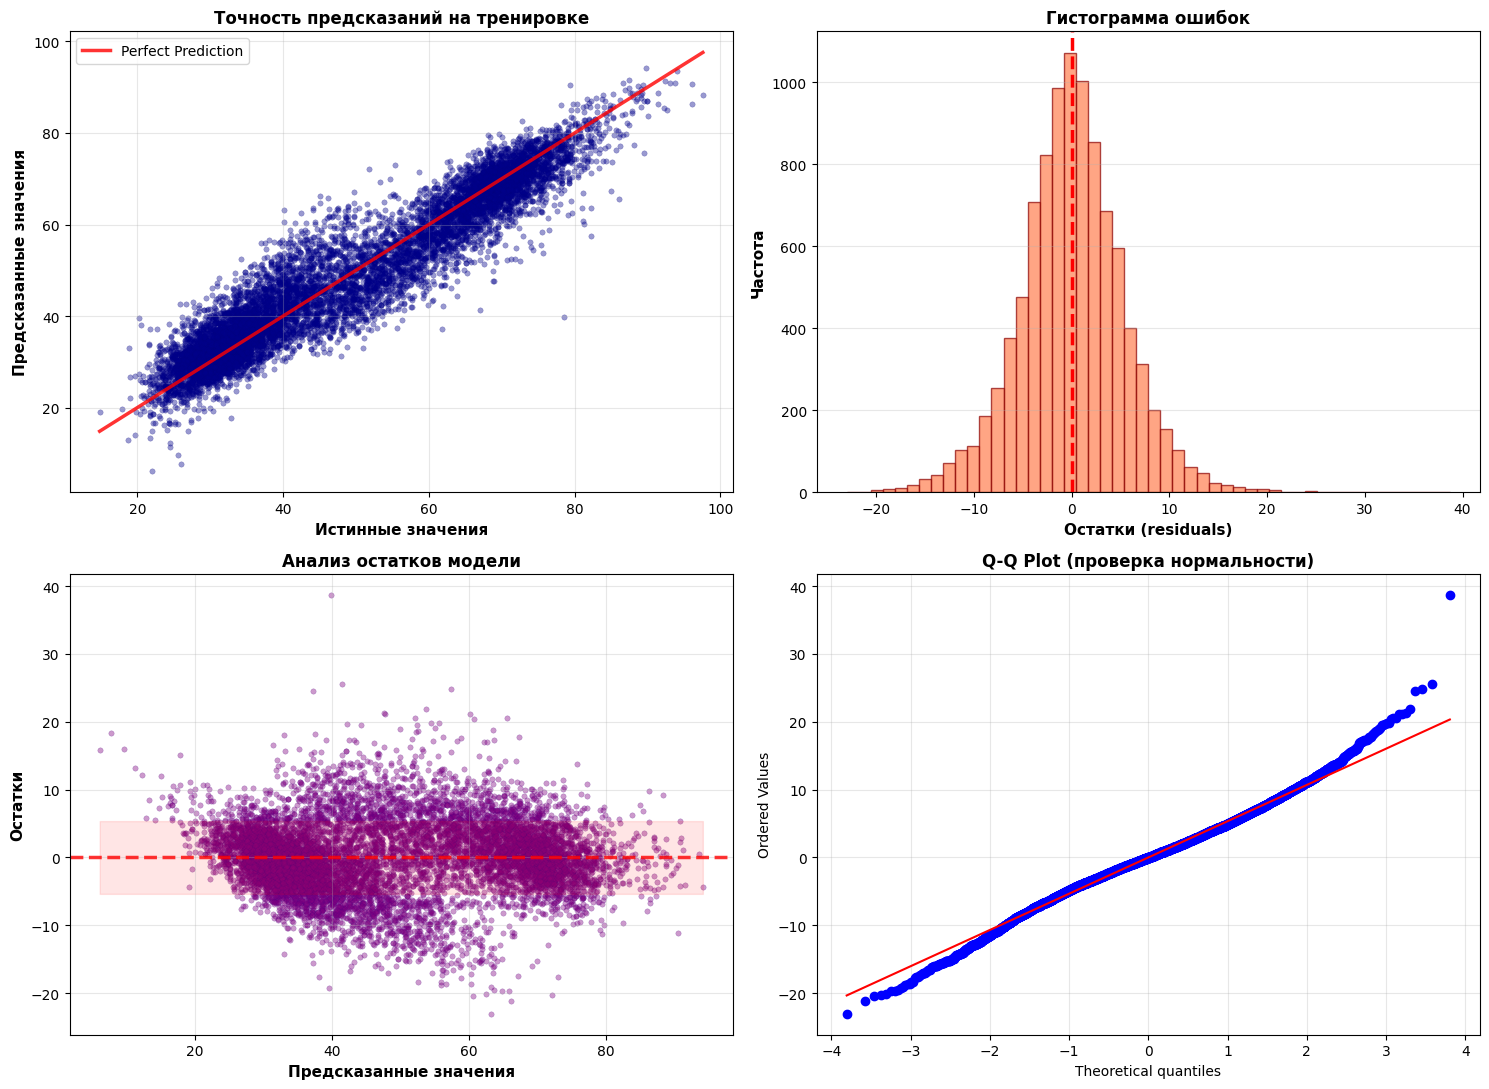


СРАВНЕНИЕ МЕТОДОВ ОБУЧЕНИЯ

                 Метод       MSE      MAE       R²  MAPE %
Analytical (Normal Eq) 28.780285 4.083148 0.903086  9.4322
      Gradient Descent 37.169978 4.785816 0.874835 11.2221
                   SGD 30.489240 4.226089 0.897332  9.7656
     Sklearn Reference 28.780285 4.083148 0.903086  9.4322

ОСНОВНАЯ МЕТРИКА ЗАДАЧИ

MSE (тренировочная выборка): 28.780285


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

axes[0, 0].scatter(y_train, y_train_pred, alpha=0.4, s=15, color='darkblue', edgecolors='navy', linewidth=0.3)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
               'r-', lw=2.5, label='Perfect Prediction', alpha=0.8)
axes[0, 0].set_xlabel('Истинные значения', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Предсказанные значения', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Точность предсказаний на тренировке', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(alpha=0.3)

residuals = y_train - y_train_pred

axes[0, 1].hist(residuals, bins=50, color='coral', alpha=0.7, edgecolor='darkred')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2.5)
axes[0, 1].set_xlabel('Остатки (residuals)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Частота', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Гистограмма ошибок', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

axes[1, 0].scatter(y_train_pred, residuals, alpha=0.4, s=15, color='purple', edgecolors='indigo', linewidth=0.3)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2.5, alpha=0.8)
axes[1, 0].fill_between(np.sort(y_train_pred), -np.std(residuals), np.std(residuals), alpha=0.1, color='red')
axes[1, 0].set_xlabel('Предсказанные значения', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Остатки', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Анализ остатков модели', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (проверка нормальности)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("СРАВНЕНИЕ МЕТОДОВ ОБУЧЕНИЯ")
print("="*80 + "\n")

comparison_results = []

model_analytical = LinearRegressionModel(method='analytical')
model_analytical.fit(X_train_normalized, y_train)
y_pred_analytical = model_analytical.predict(X_train_normalized)
comparison_results.append({
    'Метод': 'Analytical (Normal Eq)',
    'MSE': f'{mse_custom(y_train, y_pred_analytical):.6f}',
    'MAE': f'{mae_custom(y_train, y_pred_analytical):.6f}',
    'R²': f'{r2_custom(y_train, y_pred_analytical):.6f}',
    'MAPE %': f'{mape_custom(y_train, y_pred_analytical):.4f}'
})

model_gd = LinearRegressionModel(method='gradient_descent', learning_rate=0.01, n_iterations=2000)
model_gd.fit(X_train_normalized, y_train)
y_pred_gd = model_gd.predict(X_train_normalized)
comparison_results.append({
    'Метод': 'Gradient Descent',
    'MSE': f'{mse_custom(y_train, y_pred_gd):.6f}',
    'MAE': f'{mae_custom(y_train, y_pred_gd):.6f}',
    'R²': f'{r2_custom(y_train, y_pred_gd):.6f}',
    'MAPE %': f'{mape_custom(y_train, y_pred_gd):.4f}'
})

model_sgd = LinearRegressionModel(method='sgd', learning_rate=0.01, n_iterations=2000, batch_size=32)
model_sgd.fit(X_train_normalized, y_train)
y_pred_sgd = model_sgd.predict(X_train_normalized)
comparison_results.append({
    'Метод': 'SGD',
    'MSE': f'{mse_custom(y_train, y_pred_sgd):.6f}',
    'MAE': f'{mae_custom(y_train, y_pred_sgd):.6f}',
    'R²': f'{r2_custom(y_train, y_pred_sgd):.6f}',
    'MAPE %': f'{mape_custom(y_train, y_pred_sgd):.4f}'
})

sklearn_model = LinearRegression()
sklearn_model.fit(X_train_normalized, y_train)
y_pred_sklearn = sklearn_model.predict(X_train_normalized)
comparison_results.append({
    'Метод': 'Sklearn Reference',
    'MSE': f'{mean_squared_error(y_train, y_pred_sklearn):.6f}',
    'MAE': f'{mean_absolute_error(y_train, y_pred_sklearn):.6f}',
    'R²': f'{r2_score(y_train, y_pred_sklearn):.6f}',
    'MAPE %': f'{mape_custom(y_train, y_pred_sklearn):.4f}'
})

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("ОСНОВНАЯ МЕТРИКА ЗАДАЧИ")
print("="*80)
print(f"\nMSE (тренировочная выборка): {mse_custom(y_train, y_train_pred):.6f}")

